In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FIGSIZE = (20, 6)

# Reading input data

There are methods in `src/read_input.py` to read data from the csv files downloaded from the INMET website

These methods take in consideration the inconsistensies regarding column names, and groups them by position, which seemed consistent for all files

In [2]:
from src.read_input import group_datasets_by_location, format_dataset

location = "A001"
years = [str(i) for i in range(2000, 2024)]
raw_data = group_datasets_by_location(location, years)
input_data = format_dataset(raw_data)
input_data.tail()

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
datetime,,,,,,,
2023-12-31 19:00:00,1252.2,0.0,63.0,28.1,26.0,2.1,5.3
2023-12-31 20:00:00,1178.8,0.0,56.0,27.7,25.8,1.9,5.2
2023-12-31 21:00:00,873.0,0.0,61.0,27.7,25.5,2.7,5.1
2023-12-31 22:00:00,104.0,0.0,72.0,25.5,23.4,2.0,4.8
2023-12-31 23:00:00,NaN,0.0,78.0,23.4,22.3,1.4,3.7


# 

# Data treatment

To reduce noise, we're grouping the data by day, using the *mean*.

These features are all optional, and both the target and index columns are configurable, so all these results should be easily replicated for any other parameter from **INMET**

In [3]:
from src.grouping_data import (
    group_df_by_day,
    make_rolling_window,
    DEFAULT_INDEX_COLUMN,
    DEFAULT_TARGET_COLUMN,
)

target = DEFAULT_TARGET_COLUMN
idx = DEFAULT_INDEX_COLUMN

by_day = group_df_by_day(input_data, idx, target)
by_day.tail()

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
datetime,,,,,,,
2023-12-27,1320.278571,0.000000,74.458333,23.858333,22.200000,1.679167,4.350000
2023-12-28,1373.750000,0.025000,79.291667,23.595833,21.608333,1.591667,3.979167
2023-12-29,1508.907143,0.000000,74.208333,24.875000,23.308333,1.791667,4.733333
2023-12-30,1358.008333,0.116667,79.416667,23.841667,22.358333,1.975000,5.220833
2023-12-31,1376.500000,0.900000,80.875000,22.600000,21.466667,2.254167,5.695833


### Outlier Analysis
Here we're doing some manual outlier analysis, using **5000** as a cap, since most values above that don't seem to represent the actual data values

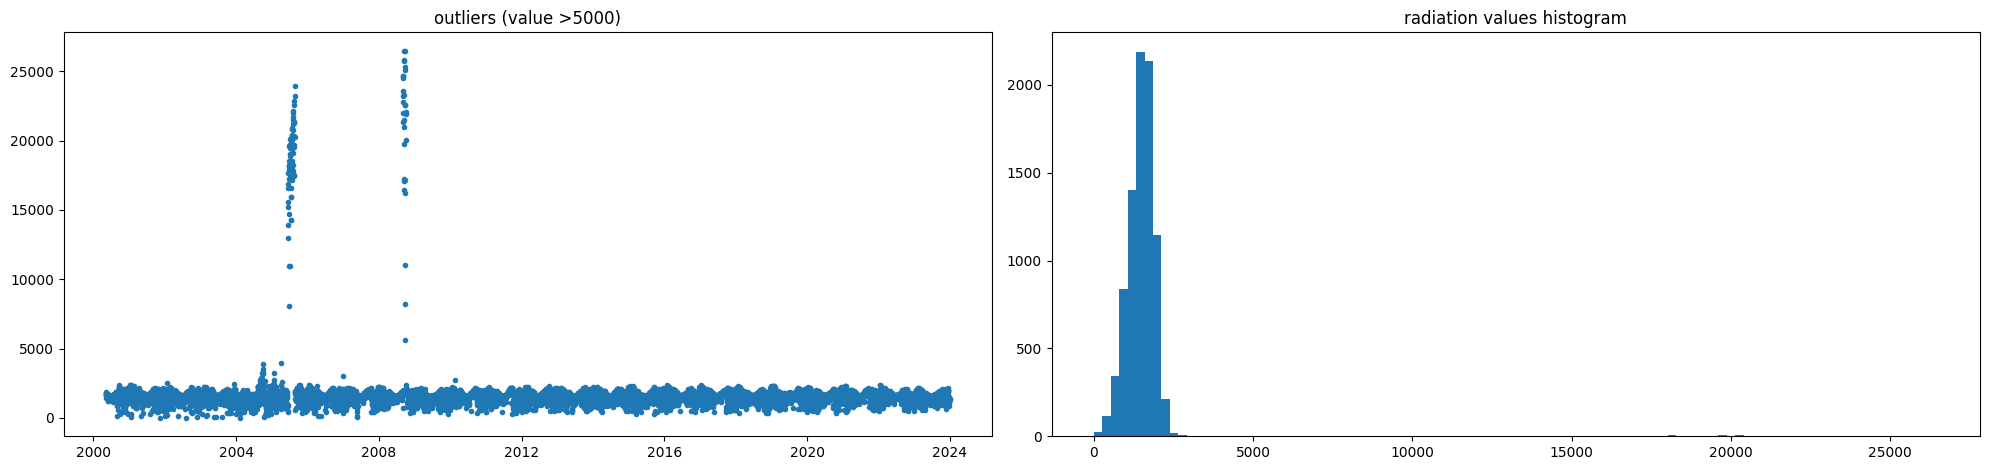

In [4]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(20)
cap = 5000

ax[0].set_title(f"outliers (value >{cap})")
ax[0].plot(by_day.loc[by_day[target] > 0, target], ".")

ax[1].set_title("radiation values histogram")
ax[1].hist(by_day[target], 100)

plt.tight_layout()

by_day = by_day.loc[by_day[target] < cap]

### Rolling mean

We decided to use a *28 days rolling mean* as a means to dampen some of the data noise, making it a bit more predictable

The number of days was chosen taking in consideration the fact that energy consumption is usually charged monthly.

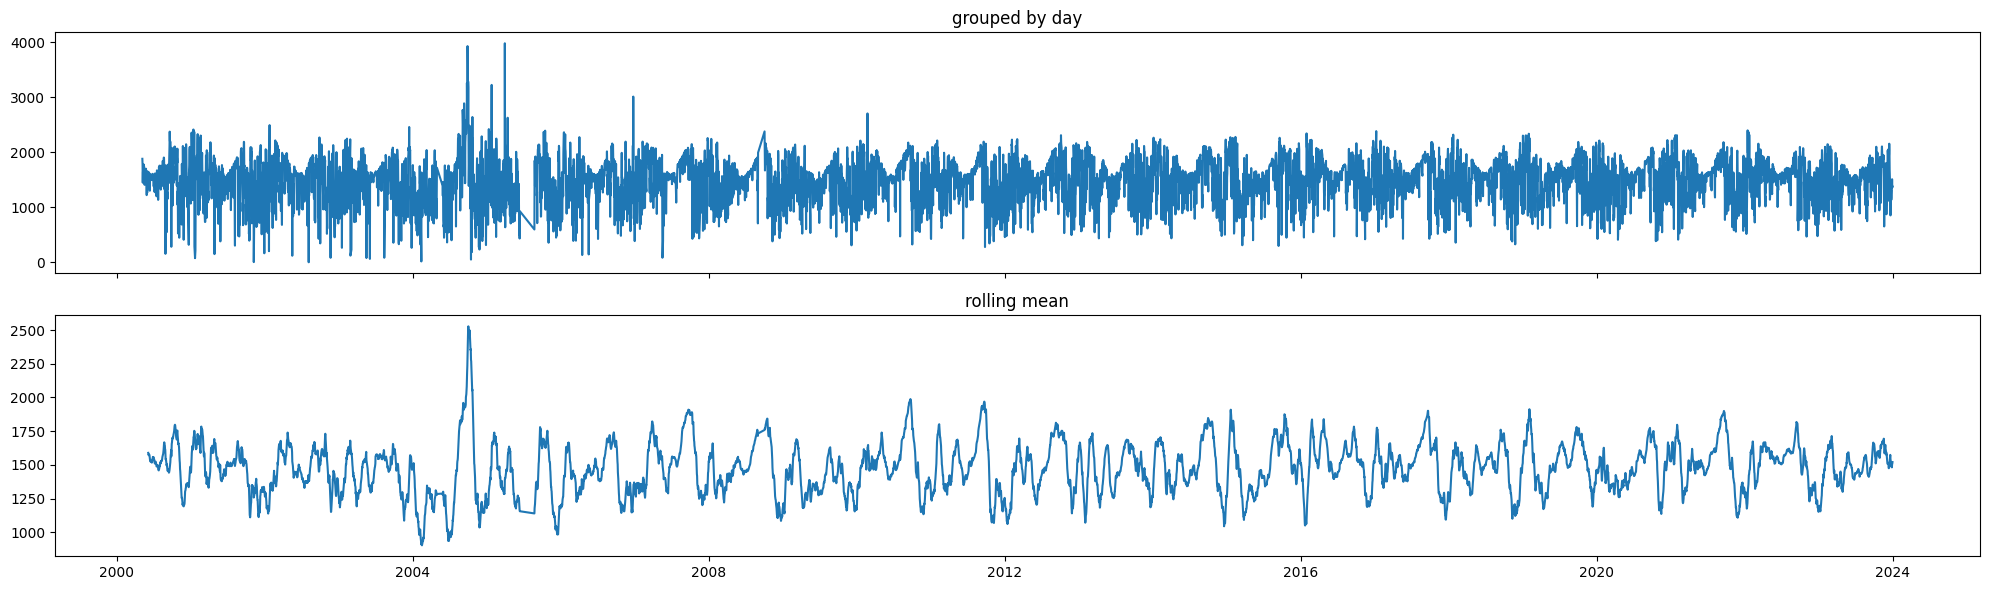

In [5]:
by_day_rolling = make_rolling_window(by_day)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
fig.set_figwidth(FIGSIZE[0])
fig.set_figheight(FIGSIZE[1])

ax1.plot(by_day[target])
ax1.set_title("grouped by day")
ax2.plot(by_day_rolling[target])
ax2.set_title("rolling mean")

fig.tight_layout()
plt.show()

# Forecast Picker

Instead of trying to tune a forecasting model, or trying to create the *best possible* in this prototype, I decided to go a _more software engineer route_, and test a class that takes an array of forecasters and automatically returns the best output

In [6]:
from src.forecasting.forecast_picker import ForecastPicker
from sklearn.metrics import mean_absolute_percentage_error

date_threshold = pd.to_datetime("2023-06-01", format="%Y-%m-%d")
upper_date_threshold = date_threshold + pd.DateOffset(years=1)

fp = ForecastPicker(
    df=by_day_rolling,
    train_threshold=date_threshold,
    test_threshold=upper_date_threshold,
    target_col=target,
    idx_col=idx,
    error_calculator=mean_absolute_percentage_error,
)

/home/fellipessanha/solar-studies/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


[0]	validation_0-rmse:1341.79318	validation_1-rmse:1373.51787
[99]	validation_0-rmse:125.37717	validation_1-rmse:176.08822


14:47:58 - cmdstanpy - INFO - Chain [1] start processing
14:47:59 - cmdstanpy - INFO - Chain [1] done processing


### How does it work?

Upon initializing, `ForecastPicker` initializes all the `BaseForecasts` given, and runs the method `BaseForecasts.evaluate_model`, which gives it a score based on the `error_calculator` passed on to `ForecastPicker`

Then it takes the best forecast and stores in `ForecastPicker.optimum_forecast`, which can be used to make predictions.

We can use the method `ForecastPicker.compare_predictions` to see how all the forecasts behave, and their respective errors

'ok'

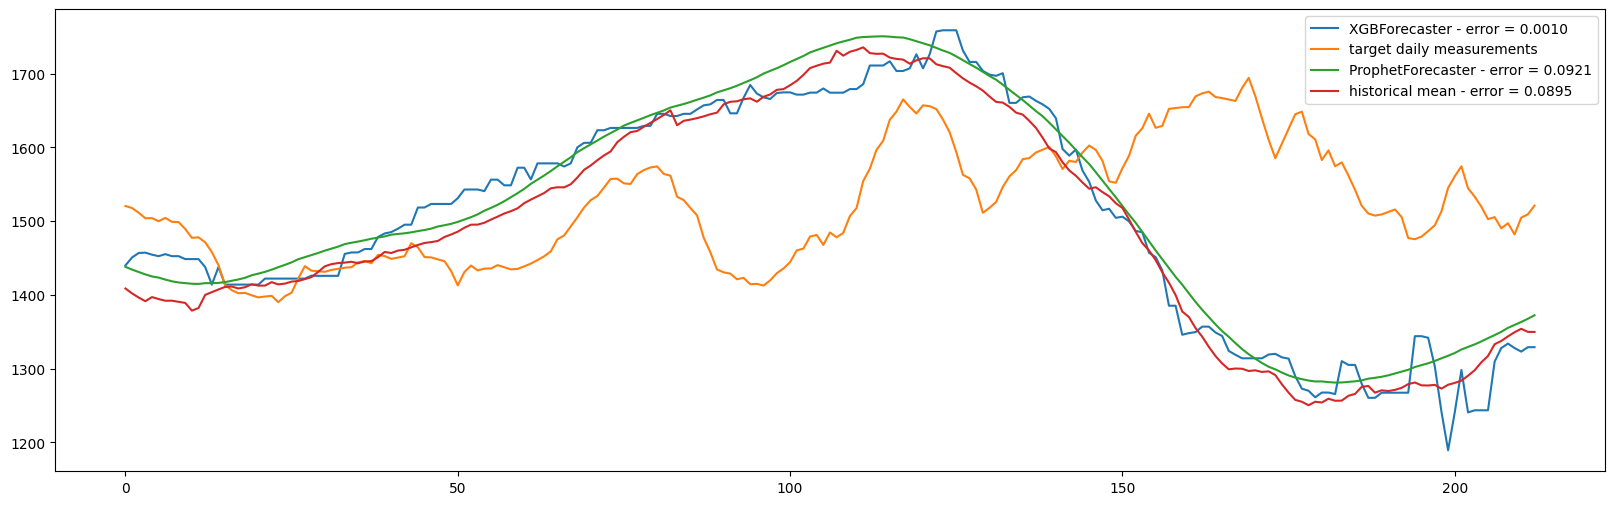

In [7]:
test_comparisons = fp.compare_predictions()

test_comparisons.plot(figsize=FIGSIZE)
"ok"

In [8]:
pred = fp.make_prediction()
pred.tail()

[0]	validation_0-rmse:1340.86379	validation_1-rmse:1340.86379
[99]	validation_0-rmse:123.24436	validation_1-rmse:123.24436


,prediction
2024-06-26,1431.919312
2024-06-27,1434.253296
2024-06-28,1436.350952
2024-06-29,1436.350952
2024-06-30,1439.790771


<Axes: >

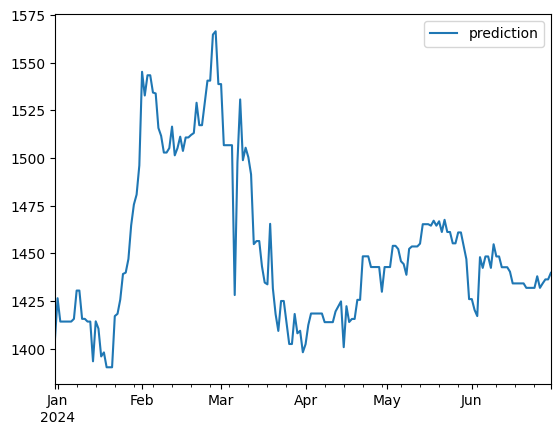

In [9]:
pred.plot()